In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

### Данные для построения приложены к домашнему заданию (data.csv)

Необходимо построить модель для задачи предсказания дефолта клиента. Целевая переменная — факт выхода клиентов в просрочку глубины 4 на горизонте 12 месяцев.

### Описание признаков

1. max_util (максимальная утилизация по КК)
2. avg_util (средняя утилизация по КК)
3. credits_2y (количество кредитов за последние 2 года)
4. credits_4y (количество кредитов за последние 4 года)
5. bad_history_credits_flg (наличие кредитов в подозрительных кредитных организациях)
6. other_util (отношение задолженности к сумме кредитов в других организациях)
7. avg_term (средний срок кредита)
8. min_term (минимальный срок кредита)
9. avg_limit_mortgage (средний лимит по ипотекам)
10. min_limit_mfo (минимальный лимит в мфо)
11. close_balance_amt (выплаченная сумма)
12. soc_dem_score (скоринговый балл основанный на соц-дем показателях)
13. max_delq_cnt (максимальное число просрочек по кредиту)
14. avg_active_time (среднее оставшееся время по открытам кредитам)
15. last_credit_time_years (время (в годах) с последнего закрытого кредита)

### Чек лист готовности работы ('x' чтобы поставить галочку)

- [x]  Признаки отобраны по ROC-AUC
- [x]  EDA проведён
- [x]  Корреляты удалены
- [x]  Градиентный бустинг обучен и достигает нужного качества
- [x]  Самые сильные признаки отобраны
- [x]  Stepwise реализован 
- [x]  Линейная модель обучена, проанализирована сила признаков 
- [x]  Метрики на тесте посчитаны
- [x]  Проведено сравнение качества моделей, выдвинуты гипотезы о причинах наблюдаемых результатов

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats.distributions import chi2
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier, plot_importance
from scipy.stats import bernoulli, norm
from plotly.subplots import make_subplots

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope



In [ ]:
df = pd.read_csv('scoring_model_data.csv')

In [ ]:
df.head()

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,0.0,0.0,2019-01-01,0.991360,0.991360,0.0,1.0,1.0,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0
1,1.0,0.0,2019-01-01,0.928482,0.271159,0.0,0.0,1.0,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0
2,2.0,0.0,2019-01-01,1.418333,0.079951,0.0,0.0,1.0,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0
3,3.0,0.0,2019-01-01,1.042425,0.230797,1.0,1.0,1.0,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0
4,4.0,1.0,2019-01-01,0.960127,0.326562,2.0,2.0,1.0,0.334188,188.200000,1.0,-1.0,-1.0,53620.00,-7.226236,0.0,14.0,2.0


In [ ]:
df = df.sort_values(by=['user_id'])

In [ ]:
df.user_id.value_counts()

0.0         2
216790.0    2
216760.0    2
216761.0    2
216762.0    2
           ..
79601.0     1
79602.0     1
79603.0     1
79604.0     1
111137.0    1
Name: user_id, Length: 222275, dtype: int64

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.user_id.value_counts()

0.0         2
148188.0    1
148177.0    1
148178.0    1
148179.0    1
           ..
74094.0     1
74095.0     1
74096.0     1
74097.0     1
222274.0    1
Name: user_id, Length: 222275, dtype: int64

In [ ]:
df = df.drop(222275)

In [ ]:
df.head()

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,0.0,0.0,2019-01-01,0.991360,0.991360,0.0,1.0,1.0,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0
1,1.0,0.0,2019-01-01,0.928482,0.271159,0.0,0.0,1.0,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0
2,2.0,0.0,2019-01-01,1.418333,0.079951,0.0,0.0,1.0,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0
3,3.0,0.0,2019-01-01,1.042425,0.230797,1.0,1.0,1.0,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0
4,4.0,1.0,2019-01-01,0.960127,0.326562,2.0,2.0,1.0,0.334188,188.200000,1.0,-1.0,-1.0,53620.00,-7.226236,0.0,14.0,2.0


In [ ]:
def train_val__test_split(df, val_frac=0.2, test_frac=0.2):
    
    X_train, X_temp, y_train, y_temp = train_test_split(df.drop(["d4p12", "user_id", "month_dt"], axis=1), 
                                                        df['d4p12'], test_size=val_frac+test_frac, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_frac, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val__test_split(df)

In [ ]:
X_train.shape

(133365, 15)

In [ ]:
isna_ind_full = X_train.isna() ^ 1

In [ ]:
isna_ind = X_train.isna().any(axis=1) ^ 1

In [ ]:
isna_ind

0         False
1          True
2          True
3          True
4          True
          ...  
133360     True
133361     True
133362     True
133363     True
133364     True
Length: 133365, dtype: bool

In [ ]:
isna = X_train.isna().sum()
isna

max_util                      0
avg_util                      0
credits_2y                    0
credits_4y                    0
bad_history_credits_flg       0
other_util                    0
avg_term                     32
min_term                     32
avg_limit_mortgage            0
min_limit_mfo                 0
close_balance_amt             0
soc_dem_score                 0
max_delq_cnt                  0
avg_active_time            7938
last_credit_time_years        0
dtype: int64

Хотя нормализация не дает особый гейн в терминах качества модели бустинга, но для последующего (более наглядного) анализа данных с целью а) заполнения пропусков и б) изучения важности признаков, 

а также ускорения сходимости логистической регрессии, используемой впоследствии, ее применение предпочтительно.

In [ ]:
features = X_train.columns
scaler = StandardScaler()
scaler.fit(X_train.loc[isna_ind])
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=features)
X_val = pd.DataFrame(data=scaler.transform(X_val), columns=features)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=features)

Посмотрим на распределние признаков (отсюда видно, почему использован именно этот scaler, а не, к примеру, min_max)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


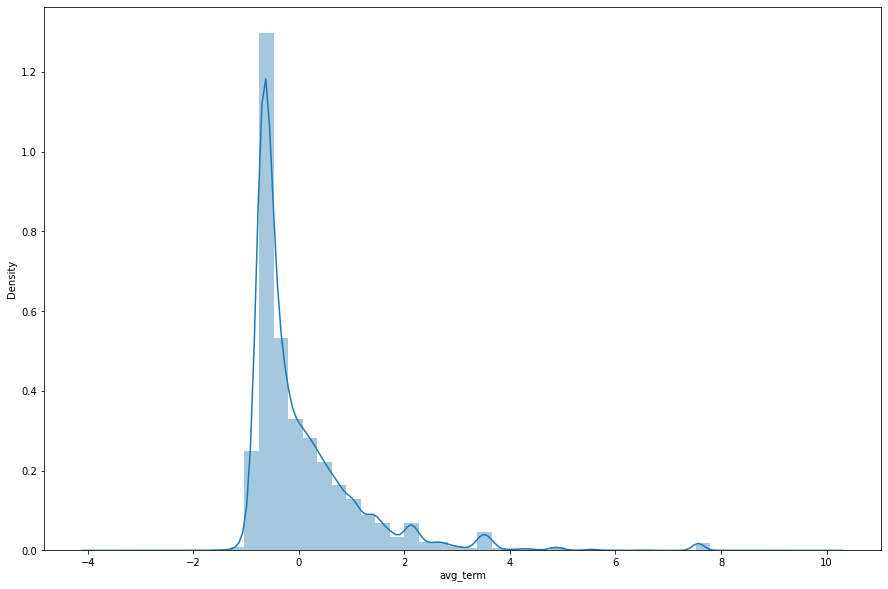

In [ ]:
fig, _ = plt.subplots(figsize=(15, 10))
sns.distplot(X_train["avg_term"].clip(-5, 10), bins=50)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


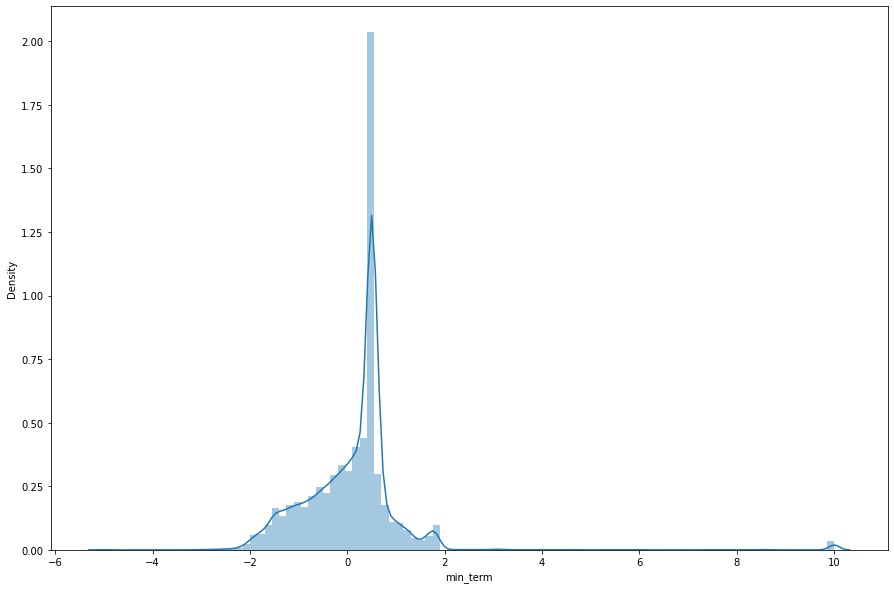

In [ ]:
fig, _ = plt.subplots(figsize=(15, 10))
sns.distplot(X_train["min_term"].clip(-5, 10), bins=100)

Заметна ассиметрия в распределении признаков $min$_$term$ и $avg$_$term$. Значит, замена пропущенных значений средним значением не рекомендуема, 
так как в таком случае оно не является мерой "центральной" тенденции данных. Одним из вариантов является замена медианой по данному признаку.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


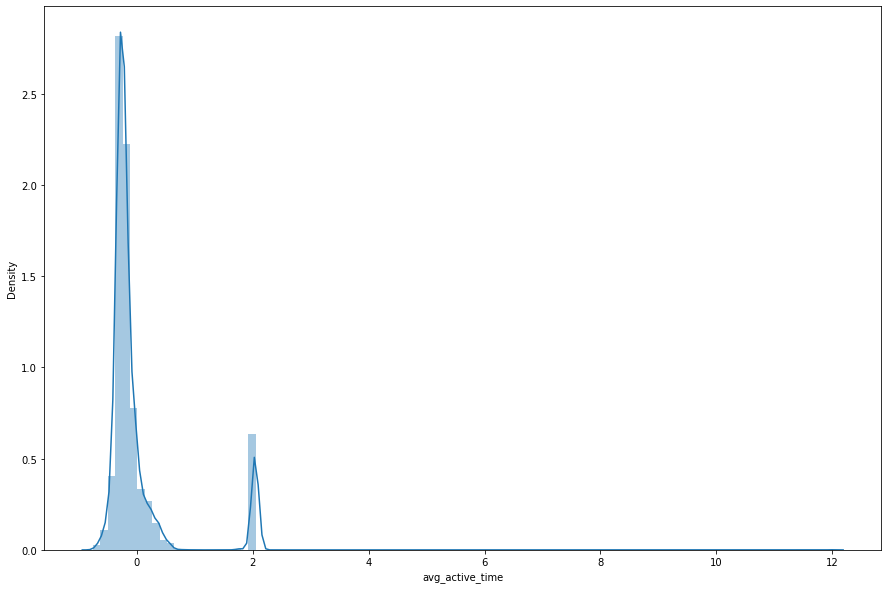

In [ ]:
fig, _ = plt.subplots(figsize=(15, 10))
sns.distplot(X_train["avg_active_time"].clip(-5, 12), bins=100)

Для признака $avg$_$active$_$time$ распределние выглядит симметричным (что является поводом использовать среднее значение), однако имеет два "холма". Эмперически установил, что из статистических характеристик медиана уместнее и для этого признака.

In [ ]:
X_nan = X_train.loc[:, isna[isna != 0].index]
to_fill_median = X_nan.median()
to_fill_mean = X_nan.mean()
col_median = ["avg_term", "min_term", "avg_active_time"]
col_mean = []
X_train.loc[:, col_median] = X_nan[col_median].fillna(to_fill_median[col_median])
X_train.loc[:, col_mean] = X_nan[col_mean].fillna(to_fill_mean[col_mean])

In [ ]:
X_nan_val = X_val.loc[:, isna[isna != 0].index]
X_nan_test = X_test.loc[:, isna[isna != 0].index]
X_val.loc[:, col_median] = X_nan_val[col_median].fillna(to_fill_median[col_median])
X_val.loc[:, col_mean] = X_nan_val[col_mean].fillna(to_fill_mean[col_mean])
X_test.loc[:, col_median] = X_nan_test[col_median].fillna(to_fill_median[col_median])
X_test.loc[:, col_mean] = X_nan_test[col_mean].fillna(to_fill_mean[col_mean])

In [ ]:
X_train.isna().sum()

max_util                   0
avg_util                   0
credits_2y                 0
credits_4y                 0
bad_history_credits_flg    0
other_util                 0
avg_term                   0
min_term                   0
avg_limit_mortgage         0
min_limit_mfo              0
close_balance_amt          0
soc_dem_score              0
max_delq_cnt               0
avg_active_time            0
last_credit_time_years     0
dtype: int64

In [ ]:
y_train.isna().sum()

0

In [ ]:
y_train

0         0.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
133360    0.0
133361    0.0
133362    0.0
133363    0.0
133364    0.0
Name: d4p12, Length: 133365, dtype: float64

**Ответ**:
Пропуски наблюдаются в статистиках по срокам кредитов и среднем оставшемся времени по кредитам.

In [ ]:
print("Уникальные значения Min term клиентов с пропусками в avg term: ", np.unique(df[df["avg_term"].isna()]["min_term"]))
print("Уникальные значения Avg term клиентов с пропусками в min term: ", np.unique(df[df["min_term"].isna()]["avg_term"]))

Уникальные значения Min term клиентов с пропусками в avg term:  [nan]
Уникальные значения Avg term клиентов с пропусками в min term:  [nan]


In [ ]:
print("Avg limit mortgage: ", np.unique(df[df["min_term"].isna()]["avg_limit_mortgage"]))
print("Min limit mfo: ", np.unique(df[df["min_term"].isna()]["min_limit_mfo"]))

Avg limit mortgage:  [-1.]
Min limit mfo:  [-1.]


Замечаем, что для *avg_term* и *min_term* значения пропущены для одних и тех клиентов => это не случайные пропуски. 
Более того, это не может быть обусловлено отсутствием у банка кредитной истории клиента, так как для некоторых таких клиентов имеются определенные значения признаков, непосредственно связанных с прошлыми кредитами. 
Единственное, что есть общее у данных объектов выборки – это "-1" для среднего лимита по ипотекам и минимальному лимиту в мфо, т.е., скоре всего, явное задание отсутствия данных. Возможно, это клиенты, для которых "потерялись" некоторые страницы кредитного договора, в частности о текущих кредитных обязательствах, которые не смогли восстановить по кредитной истории (не заполнить их клиент не мог, так как на сканах произвольного найденного мной договора видно, что это поле обязательное). 

In [ ]:
print(len(df[df["avg_active_time"] == 0]))
print(len(df[df["avg_active_time"].isna()]))

2185
13710


Пропусков по времени по текущим кредитам гораздо больше, чем для вышеразобранных признаков (причем первое множество содержит второе). При этом в выборке есть как отрицательные (просрочка), положительные, так и нулевые значения. При этом нулевых 2185 (из 133,000+). Вероятность того, что нуль – это сугубо среднее отрицательных и положительных чисел, а в качестве признака отсутствия идет Только Nan, крайне низка (т.к. 2,000 сэмплов, а такая подборка текущего времени открытых кредитов маловероятна сама по себе). Но и отсутствие кредитов на данный момент лишь у 1.5% клиентов в выборке вряд ли соответствует реальности. Сумма 0 и Nan приводит к уже более правдоподобным 10% без кредитов. Отсюда следует, что Nan может стоять у людей, которые не имеют на данный момент кредитов, вследствие коллизий в обозначениях в анкетах.

In [ ]:
def filter_by_roc_auc(X, y, with_filled_nan=True, ind=None):
    metrics = dict()
    for feature in X.columns:
        if not with_filled_nan:
            rows = ind[feature]
            f_col = X.loc[rows, feature]
            y_col = y.loc[rows]
        else:
            f_col = X.loc[:, feature]
            y_col = y.loc[:]
        metrics[feature] = max(roc_auc_score(y_col, f_col), 1 - roc_auc_score(y_col, f_col))
    return pd.Series(metrics).sort_values(ascending=False)

In [ ]:
roc_auc_scores = filter_by_roc_auc(X_train, y_train, with_filled_nan=False, ind=isna_ind_full)

In [ ]:
roc_auc_scores

max_util                   0.620362
last_credit_time_years     0.597328
soc_dem_score              0.596123
avg_util                   0.591869
other_util                 0.590132
credits_4y                 0.575102
credits_2y                 0.565935
min_limit_mfo              0.546784
close_balance_amt          0.544901
avg_limit_mortgage         0.537355
avg_active_time            0.530031
avg_term                   0.522395
min_term                   0.504046
bad_history_credits_flg    0.503988
max_delq_cnt               0.500542
dtype: float64

In [ ]:
selected_features = roc_auc_scores[roc_auc_scores > 0.525].keys()

##### EDA

In [ ]:
X_train[roc_auc_scores.index[:3]].describe()

,max_util,last_credit_time_years,soc_dem_score
count,133365.000000,133365.000000,133365.000000
mean,-0.004078,-0.018336,0.005514
std,0.974377,0.974138,0.999845
min,-0.131565,-0.474881,-4.414749
25%,-0.065853,-0.474881,-0.665361
50%,-0.043225,-0.134455,0.012473
75%,-0.038432,0.205970,0.682126
max,169.533066,67.950679,4.228090


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3631b84290>,
      dtype=object)

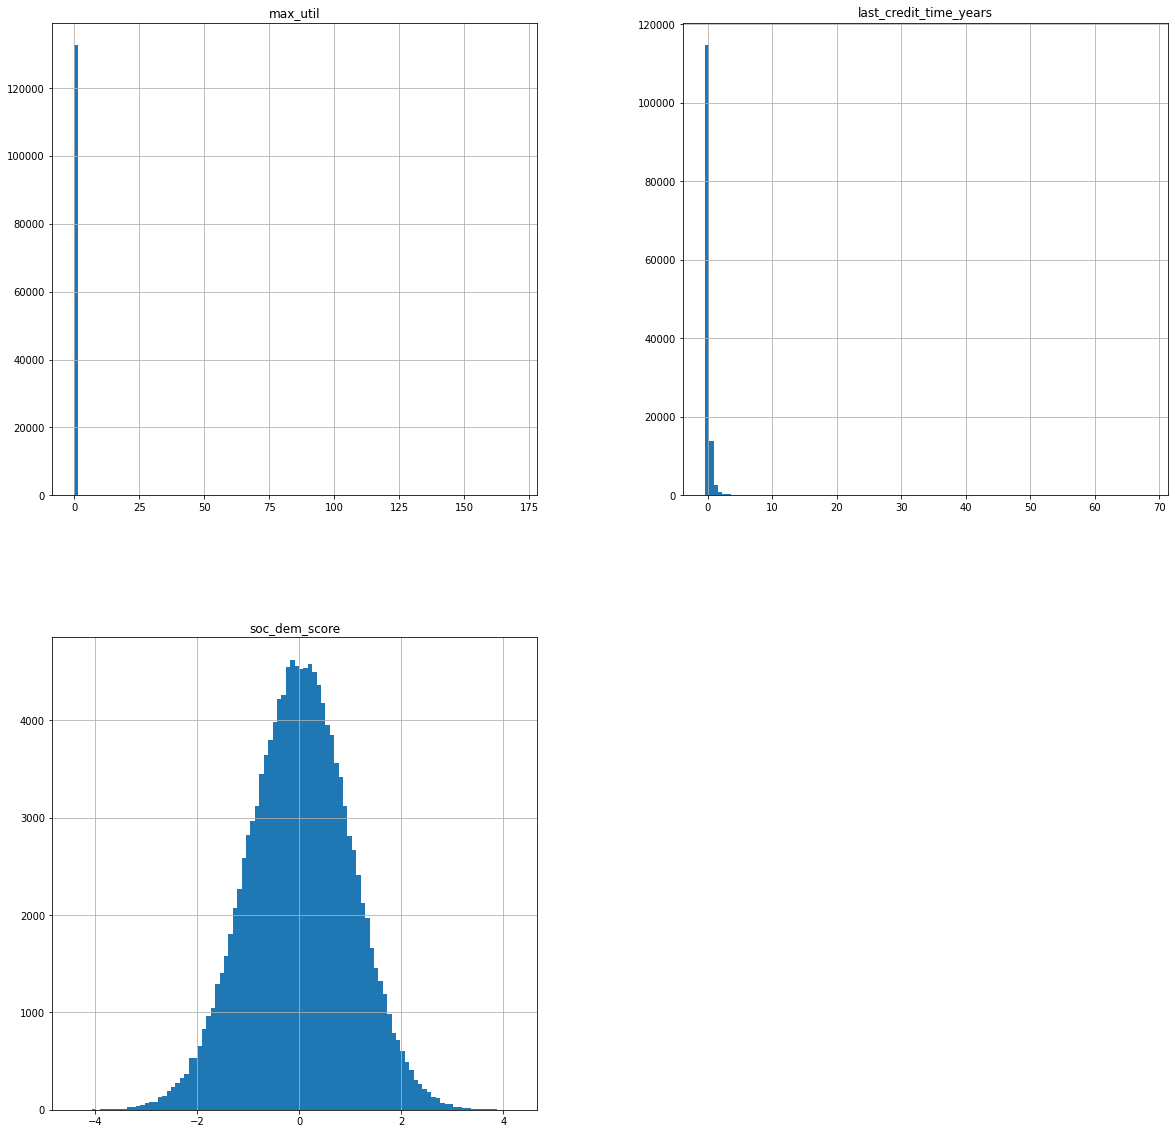

In [ ]:
X_train[roc_auc_scores.index[:3]].hist(figsize=(20, 20), bins=100)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


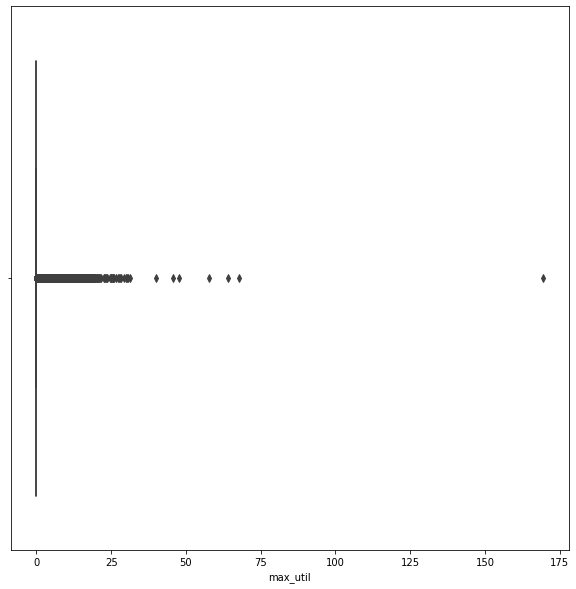

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(X_train["max_util"], whis=1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


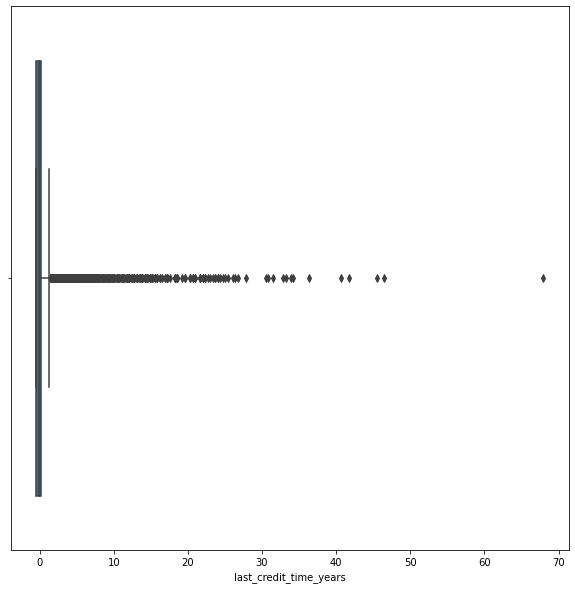

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(X_train["last_credit_time_years"], whis=1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


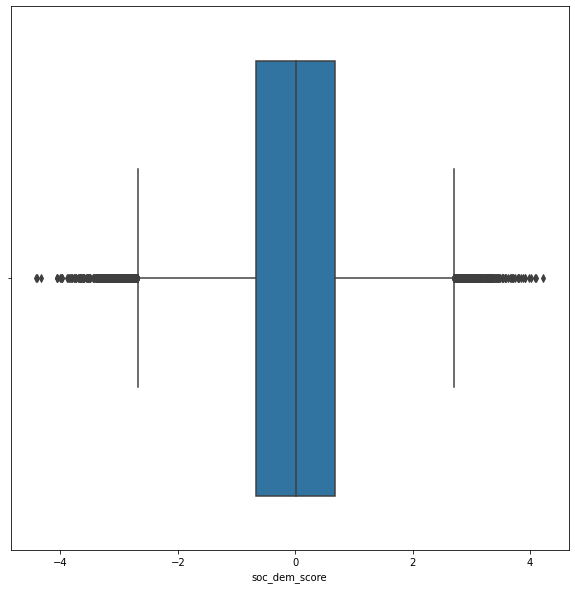

In [ ]:
plt.figure(figsize=(10, 10))
sns.boxplot(X_train["soc_dem_score"], whis=1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


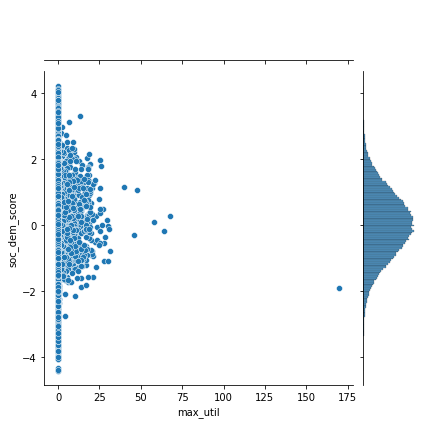

In [ ]:
sns.jointplot(X_train["max_util"], X_train["soc_dem_score"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


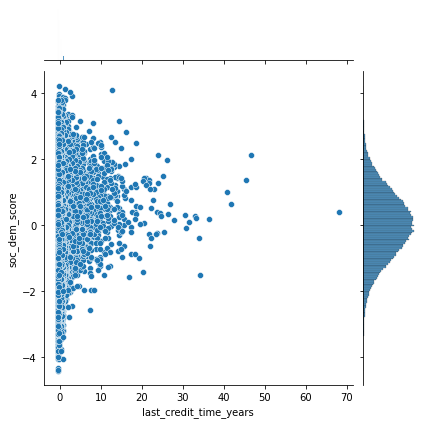

In [ ]:
sns.jointplot(X_train["last_credit_time_years"], X_train["soc_dem_score"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


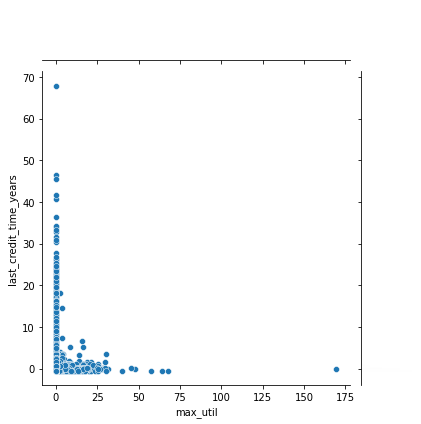

In [ ]:
sns.jointplot(X_train["max_util"], X_train["last_credit_time_years"])

Значения *max_util* до масштабирования лежат преимщуественно на вещественной прямой в интервале (0, 1). Если отсечь выбросы, признак можно интерпретировать как вероятность (классическую). 

*last_credit_time_years* имеет распределение, сильно смещенное в сторону нуля.
 
*soc_dem_score* после масштабирования имеет симметричное нормальное распределение (то есть отклонения в обе стороны равновероятны) со средним в нуле (до нормализации распределение так же нормальное, однако наиболее вероятным значением является -6).

*max_util* и *last_credit_time_years* имеют следующую зависимость: чем больше один признак, тем сильнее второй признак "прижат" к нулю. Это объясняется трактованием признаков: если у человека на данный момент имеется высокая задолженность, то кредит активен на данный момент, поэтому лет с последнего кредита прошло 0. И наоборот, чем раньше был взят кредит, тем в общем случае меньше задолженность по нему (включая событие просрочки кредита)

Что касается вида выборки в координатах *soc_dem_score* и *max_util* / *last_credit_time_years* – она подчинена распределению, очень похожему на нормальное. Чем значение *soc_dem_score*  популярнее для данного объекта, тем больше для него значение других признаков.

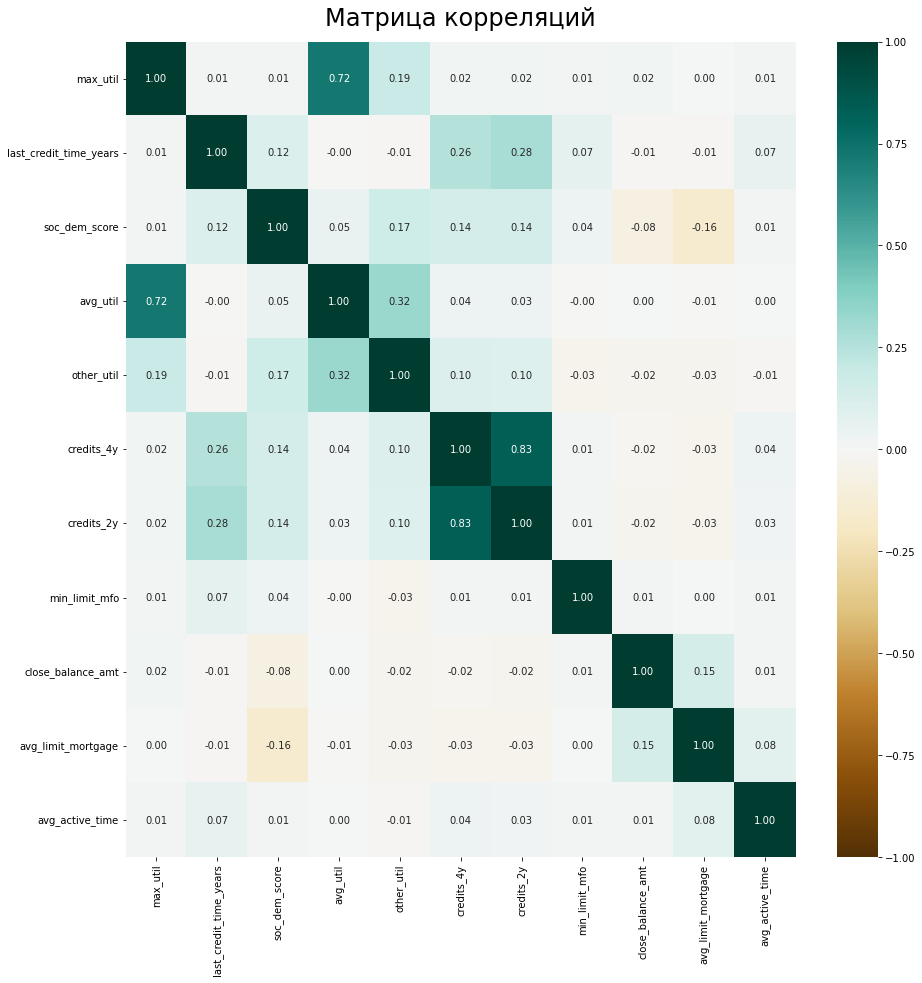

In [ ]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(X_train[selected_features].corr(), mask=None, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f")
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

В качества порога возьмем 0.2

Особенно проблемными в терминах мультиколлинеарности признаками представляются 3 группы: *credits_2y* – *credits_4y* – *last_credit_time_years*;   *avg_util* – *max_util* – *other_util*;  *avg_limit_mortgage* – *close_balance_amt*

In [ ]:
def check_coef(X, f1_name, f2_name, y):
    model_1 = LogisticRegression(penalty='none', max_iter=1000)
    model_1.fit(np.array(X.loc[:, f1_name]).reshape(-1,1), y)
    model_2 = LogisticRegression(penalty='none', max_iter=1000)
    model_2.fit(np.array(X.loc[:, f2_name]).reshape(-1,1), y)
    model_3 = LogisticRegression(penalty='none', max_iter=1000)
    model_3.fit(X.loc[:, [f1_name, f2_name]], y)
    return model_1.coef_[0][0], model_2.coef_[0][0], model_3.coef_[0]

При обучении на 2 признаках зависимость изменилась на обратную – явный признак мультиколлинеарности. Более того, признак *max_util* при обучении бустинга всегда трактуется как топ-1 по важности с большим отрывом (как и при отборе по roc-auc) поэтому оставляем именно его.

In [ ]:
check_coef(X_train, "avg_util", "max_util", y_train)

(0.04326712243957435, 0.027781994652363327, array([ 0.05162629, -0.011099  ]))

Так как данные отмасштабированы, можем в качестве критерия важности использовать регрессию, а именно ее коэффициенты. 

In [ ]:
check_coef(X_train, "credits_2y", "credits_4y", y_train)

(0.24059407222286636, 0.25676270507144877, array([0.09336743, 0.17746164]))

In [ ]:
check_coef(X_train, "close_balance_amt", "avg_limit_mortgage", y_train)

(-0.26440390394094204, -0.3127110504075123, array([-0.14298855, -0.29205128]))

Таким образом, оставляем 
* *credits_4y* (+ руководствуемся тем, что за 2 года финансовое положение почти наверняка осталось таким же, но при этом период в 4 года, очевидно, содержит больше информации.)
* *avg_limit_mortgage* (кажется, что по такому признаку, как "выплаченная сумма", тяжело определить тенденцию выборки людей относительно бинарного ответа на вопрос о справедливости факта своевременного погашения задолженности. В задаче определения суммы задолженности на момент дедлайна этот признак мог бы играть более значительную роль. В данной же задаче в **cовокупности с другими признаками** более важным интуитивно кажется средний лимит по ипотекам.



In [ ]:
selected_features = list(selected_features)

In [ ]:
selected_features.remove("credits_2y")

In [ ]:
selected_features.remove("close_balance_amt")

In [ ]:
selected_features.remove("avg_util")

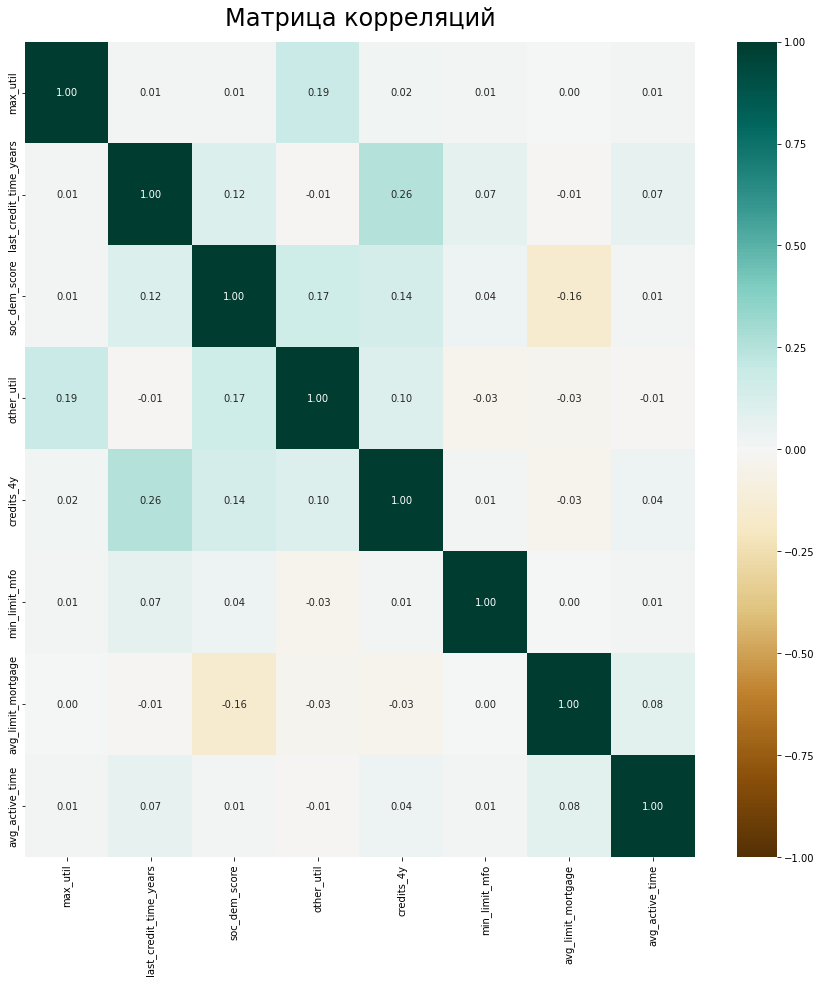

In [ ]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(X_train[selected_features].corr(), mask=None, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f")
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

Из признаков, превышающих выбранный порог, осталась пара *last_credit_time_years*, *credits_4y*

In [ ]:
check_coef(X_train, "last_credit_time_years", "credits_4y", y_train)

(0.1612248018433439, 0.25676270507144877, array([0.12514195, 0.22486386]))

Отбираем *credits_4y* (признак "время последнего кредита", несмотря на высокую позицию по roc-auc отбору, может быть нерепрезентативным, как минимум, по 2 причинам: 1) финансовое положение человека могло измениться за много лет и 2) только что закрытый кредит может обозначать как отсутствие финансов на новый, так и наличие активных вложений в проект, прибыль от которого в короткий срок позволит нивелировать задолженность.

In [ ]:
selected_features.remove("last_credit_time_years")

In [ ]:
selected_features

['max_util',
 'soc_dem_score',
 'other_util',
 'credits_4y',
 'min_limit_mfo',
 'avg_limit_mortgage',
 'avg_active_time']

Для подбора наиболее оптимальных параметров воспользуемся hyper-opt (для экономии времени (дополнительной, так как lightbfm сам по себе является наиболее быстрой реализацией бустинга) и учета эвристик, которые, возможно, мы могли бы упустить)

Не будем использовать кросс-валидацию, чтобы случайно не нарушить требования по работе с данными в задании

In [ ]:
import warnings
warnings.filterwarnings("ignore")

trials = Trials()

def quality_cross_val(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    lgbm = LGBMClassifier(**params)
    
    # Для кросс-валидации объединим валидационную и тренировочную выборки с сохранением размера выборки, использующейся 
    # для проверки качества при текущих гиперпараметрах (чтобы не нарушать условий задания). 
    # Для этого поставим число фолдов = 4 (train – 0.6, val – 0.2)
    roc_auc = cross_val_score(lgbm, pd.concat([X_train, X_val])[selected_features], pd.concat([y_train, y_val]), 
                          cv=4, scoring='roc_auc')
    print(roc_auc.mean(), params)
    return -roc_auc.mean()


def quality(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    lgbm = LGBMClassifier(**params, random_state=0)
    lgbm.fit(X_train[selected_features], y_train)
    roc_auc = roc_auc_score(y_val, lgbm.predict_proba(X_val[selected_features])[:, 1])
    #print(roc_auc, params)
    return -roc_auc

grid = {'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
       'max_depth' : hp.quniform('max_depth', 1, 10, 1),
       'learning_rate': hp.loguniform('learning_rate', -3, 0)
      }

Выставляем 30 итераций. 

In [ ]:
best = fmin(fn=quality,
                space=grid,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials,
               verbose= 1)
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])

100%|██████████| 50/50 [01:46<00:00,  2.13s/it, best loss: -0.6538258654109903]


In [ ]:
best

{'learning_rate': 0.0504742858936961, 'max_depth': 9, 'n_estimators': 80}

In [ ]:
lgbmc = LGBMClassifier(**best, importance_type="gain", random_state=0)
lgbmc.fit(X_train[selected_features], y_train)

LGBMClassifier(importance_type='gain', learning_rate=0.0504742858936961,
               max_depth=9, n_estimators=80, random_state=0)

In [ ]:
print(f"Качество LGBM классификатора на валидационной выборке {roc_auc_score(y_val, lgbmc.predict_proba(X_val[selected_features])[:, 1])}")

Качество LGBM классификатора на валидационной выборке 0.6538258654109903


In [ ]:
print(f"Качество LGBM классификатора на тестовой выборке {roc_auc_score(y_test, lgbmc.predict_proba(X_test[selected_features])[:, 1])}")

Качество LGBM классификатора на тестовой выборке 0.646955301021815


Text(0.5, 1.0, 'Сила признаков бустинга')

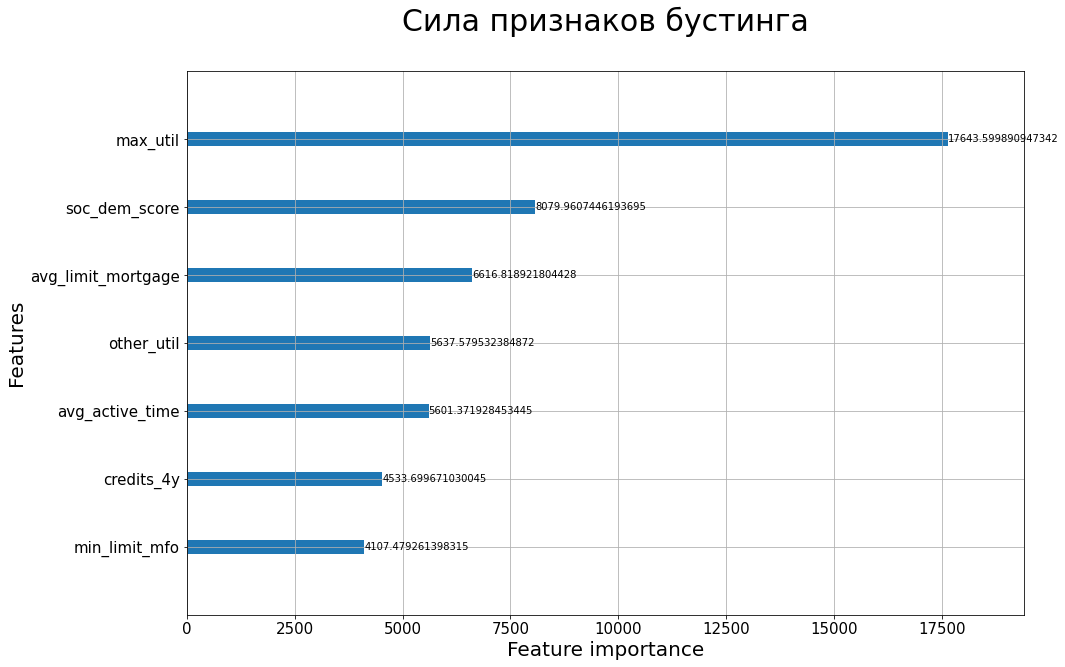

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_xlabel('Feature importance', fontsize=20)
ax.set_ylabel('Features', fontsize=20)
plot_importance(lgbmc, max_num_features=7, importance_type='gain', figsize=(15, 15), ax=ax)
plt.title("Сила признаков бустинга", fontsize=30, pad=40)

**Ответ**: Самый сильный признак *max_util* (в терминах gain, т.е. эта фича сильнее всего снижает неопределенность модели, если агрегировать по всем деревьям). Это максимальное по всем кредиткам отношение задолженности к лимиту. Ниже это значение => {верхняя граница} => ниже все отношения долга к лимиту => {лимит = const} => ниже задолженность по всем картам => выше уровень доверия к клиенту и ниже вероятность выхода клиента в просрочку. При этом статистика max позволяет накладывать исчерпывающие ограничения на распределение задолженности по картам: высокое значение отношения задолженности с лимиту не будет компенсироваться его низкими значениями по бесконечному количеству карт с нулевой задолженностью (как в случае с average). 

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
def stepwise_selection(X, features, y, alpha_in=0.1, alpha_out=0.15):
    selected_features = list()
    p_value_in = 1
    p_value_out = 0
    it = -1
    while True:
        it += 1
        print("Iteration ", it)
        potential_features = list(set(features) - set(selected_features))
        best_feature = ''
        for feature in potential_features:
            temp_features = [feature] + selected_features
            lr_short = LogisticRegression(penalty='none', max_iter=500)
            lr_long = LogisticRegression(penalty='none', max_iter=500)
            if len(selected_features) == 0:
                f_short = np.ones(X.shape[0]).reshape(-1, 1)
                f_long = np.array(X[temp_features]).reshape(-1, 1)
            else:
                f_short = X[selected_features]
                f_long = X[temp_features]
            lr_short.fit(f_short, y)
            ll_short = log_loss(y, lr_short.predict_proba(f_short)[:, 1], normalize=False) 
            lr_long.fit(f_long, y)
            ll_long = log_loss(y, lr_long.predict_proba(f_long)[:, 1], normalize=False)
            
            llrt = likelihood_ratio_test(ll_short, ll_long)
            
            if llrt <= alpha_in and llrt < p_value_in:
                p_value_in = llrt
                best_feature = feature
                
        if best_feature == '':
            break
        selected_features.append(best_feature)
        print(f"{best_feature} was added to your model by showing p-value = {round(p_value_in, 4)}")
        p_value_in = 1
        
        
        worst_feature = ''
        for feature in selected_features:
            temp_features = [el for el in selected_features if el != feature]
            lr_short = LogisticRegression(penalty='none', max_iter=500)
            lr_long = LogisticRegression(penalty='none', max_iter=500)
            if len(temp_features) == 0:
                f_short = np.ones(X.shape[0]).reshape(-1, 1)
                f_long = np.array(X[selected_features]).reshape(-1, 1)
            else:
                f_long = X[selected_features]
                f_short = X[temp_features]
            lr_short.fit(f_short, y)
            ll_short = log_loss(y, lr_short.predict_proba(f_short)[:, 1], normalize=False) 
            lr_long.fit(f_long, y)
            ll_long = log_loss(y, lr_long.predict_proba(f_long)[:, 1], normalize=False)
            
            llrt = likelihood_ratio_test(ll_short, ll_long)
            
            if llrt > alpha_out and llrt > p_value_out:
                p_value_out = llrt
                worst_feature = feature
        p_value_out = 0
        
        if worst_feature == '':
            continue
        selected_features = [el for el in selected_features if el != worst_feature]
        print(f"{worst_feature} was removed from your model by showing p-value = {round(p_value_out, 4)}")
        
    return selected_features

In [ ]:
selected_features_sw = stepwise_selection(X_train, selected_features, y_train)

Iteration  0
soc_dem_score was added to your model by showing p-value = 0.0
Iteration  1
credits_4y was added to your model by showing p-value = 0.0
Iteration  2
other_util was added to your model by showing p-value = 0.0
Iteration  3
avg_limit_mortgage was added to your model by showing p-value = 0.0
Iteration  4
min_limit_mfo was added to your model by showing p-value = 0.0
Iteration  5
avg_active_time was added to your model by showing p-value = 0.0
Iteration  6


In [ ]:
log_reg = LogisticRegression(penalty='none', fit_intercept=True, max_iter=1000)
log_reg.fit(X_train[selected_features_sw], y_train)

LogisticRegression(max_iter=1000, penalty='none')

Text(0.5, 1.0, 'Сила признаков линейной модели')

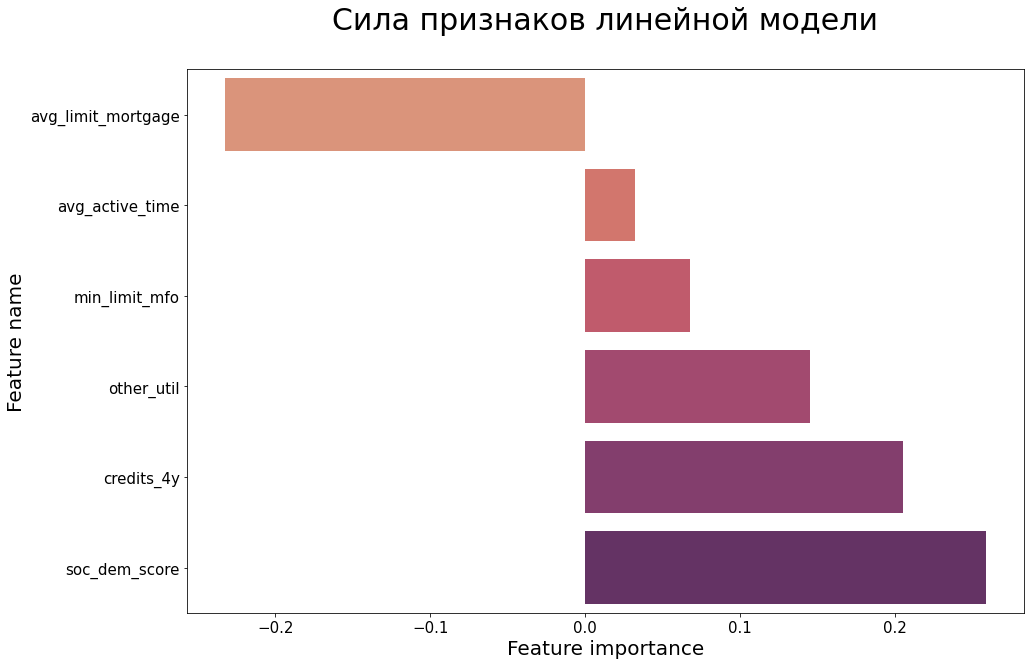

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
coef = pd.DataFrame(log_reg.coef_[0],index=selected_features_sw, columns=['feature_importance']).sort_values(by=['feature_importance'])
plot = sns.barplot(y=coef.index, x=coef['feature_importance'], palette="flare")
ax.set_xlabel('Feature importance', fontsize=20)
ax.set_ylabel('Feature name', fontsize=20)
plt.title("Сила признаков линейной модели", fontsize=30, pad=40)

**Ответ**: Stepwise селекция исключила самый мощный признак бустинга, но ранги большинства фичей сохранились / поменялись несильно. Так, soc_dem_score осталась самой сильной из множества отобранных ранее фичей за вычетом max_util. Самой слабой оказалась avg_active_time, которая и раньше занимала низкую позицию по важности. Однако credits_4y стал 3 по значимости, будучи на второй позиции с конца в бустинге. 

Возможно, одной из причин может быть явление omitted-variable bias, которое возникло вследствии исключение max_util. Смещение коэффициентов модели наступает при удалении "нужных" модели признаков, от которых одни признаки зависят, а другие коррелирует с ними (из хитмапа выше видно, что max_util имеет далеко не нулевые корреляции с other_util).

Из дополнительной информации, извлекаемой из данного графика, можно выделить характер зависимости между таргетом и конкретным признаком: avg_limit_mortgage единственная фича, предполагающая увеличение таргета при собственном убывании. 

In [ ]:
print(f"Качество логистической регрессии на валидационной выборке {roc_auc_score(y_train, log_reg.predict_proba(X_train[selected_features_sw])[:, 1])}")

Качество логистической регрессии на валидационной выборке 0.6395049242083206


In [ ]:
print(f"Качество логистической регрессии на валидационной выборке {roc_auc_score(y_val, log_reg.predict_proba(X_val[selected_features_sw])[:, 1])}")

Качество логистической регрессии на валидационной выборке 0.6201660876156687


In [ ]:
print(f"Качество логистической регрессии на тестовой выборке {roc_auc_score(y_test, log_reg.predict_proba(X_test[selected_features_sw])[:, 1])}")

Качество логистической регрессии на тестовой выборке 0.6068284989538025


In [ ]:
train = []
val = []
test = []
c_array = np.logspace(-6, -2, 3)
for c in c_array:
  model = LogisticRegression(C=c, fit_intercept=True, max_iter=2000)
  model.fit(X_train[selected_features_sw], y_train)
  train.append(roc_auc_score(y_train, model.predict_proba(X_train[selected_features_sw])[:, 1]))
  val.append(roc_auc_score(y_val, model.predict_proba(X_val[selected_features_sw])[:, 1]))
  test.append(roc_auc_score(y_test, model.predict_proba(X_test[selected_features_sw])[:, 1]))

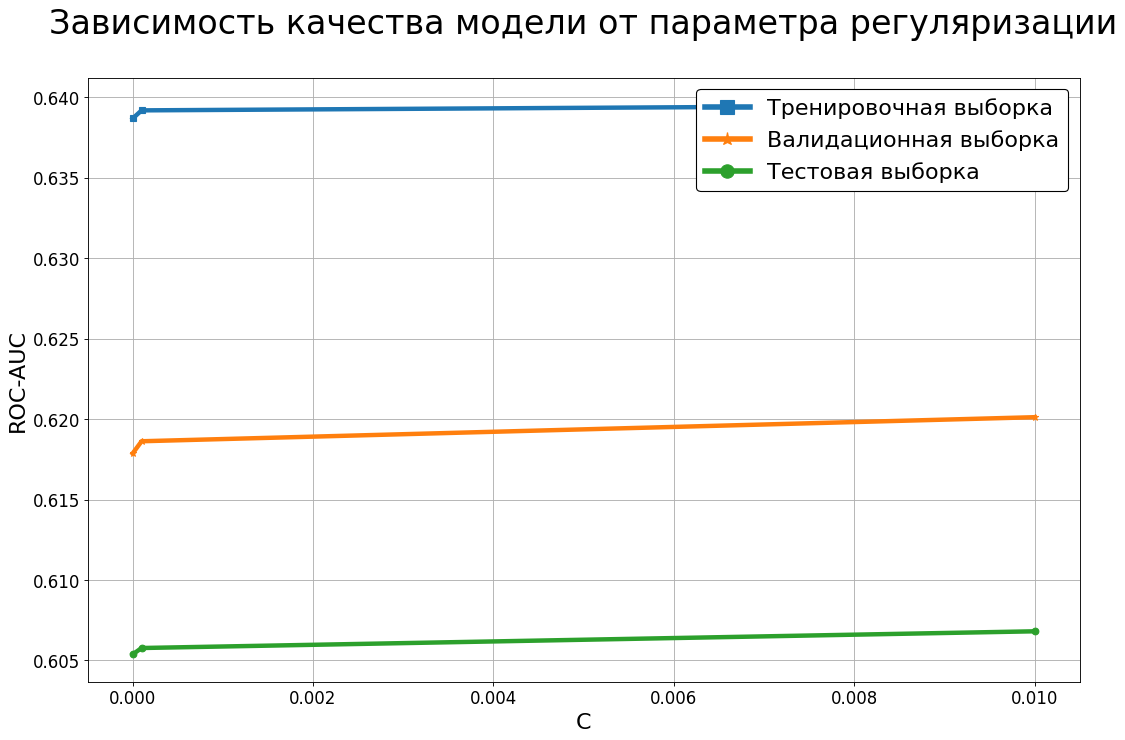

In [ ]:
fig, ax = plt.subplots(figsize=(16,10), dpi=80)
plt.plot(c_array, train, label = "Тренировочная выборка", linewidth=4, marker='s')
plt.plot(c_array, val, label = "Валидационная выборка",linewidth=4, marker='*')
plt.plot(c_array, test, label = "Тестовая выборка",linewidth=4, marker='o')
leg = plt.legend(ncol=1, loc=1, title_fontsize=20, fontsize=20, framealpha=1,
                     markerscale=2,edgecolor='black')
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
leg.get_lines()[0].set_linewidth(5)
leg.get_lines()[1].set_linewidth(5)
leg.get_lines()[2].set_linewidth(5)
plt.title("Зависимость качества модели от параметра регуляризации", fontsize=30, pad=40)
ax.set_xlabel('C', fontsize=20)
ax.set_ylabel('ROC-AUC', fontsize=20)
plt.grid(True)

**Ответ**: Качество на тесте отличается на ~0.4 от качества на тренировочной выборке и на ~0.2 от качества на валидационной. 
Если при этом подключить регуляризацию, которая является инструментом борьбы с переобучением, то качество на тренировочной выборке так же остается ниже, чем на валидационной выборке и тестовой. 
В целом назвать данное явление переобучением нельзя, так как такую разницу в значениях метрики сложно назвать существенной. 
Тем не менее, принимая во внимание то, что выборки отсортированы по времени и значения метрики монотонно убывает (пусть и всего 3 точки) со временем (от трейна до теста), можно предположить, что на совсем свежих данных модель не сможет отражать реальные (релевантные) зависимости.

При этом качество линейной модели значительно ниже качества, полученного с помощью бустинга. Это объясняется, в первую очерель, отсутствием специфической обработки данных (линеаризация признаков, заполнение пропусков нулевым значением по WoE) и простотой данной модели (в том числе отсутствием возможности улучшить модель подбором множества гиперпараметров пусть даже в ущерб универсальности модели)